In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import keras_tuner as kt

In [16]:
data = pd.read_csv("datos_preprocesados.csv", parse_dates=['fecha'], index_col='fecha')
data = data.asfreq('D')

In [17]:
end_train = '2021-12-31'
end_validation = '2023-08-11'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2019-01-01 00:00:00 --- 2021-12-31 00:00:00  (n=1096)
Dates validacion : 2021-12-31 00:00:00 --- 2023-08-11 00:00:00  (n=589)
Dates test       : 2023-08-11 00:00:00 --- 2024-09-18 00:00:00  (n=405)


In [11]:
# Separar la variable objetivo y las variables exógenas
target_column = 'demanda'
#exogenous_columns = data.columns.difference([target_column]).tolist()
exogenous_columns = ['diasem', 'trim', 'festivo', 'tmed']

# Escalar solo la columna objetivo
scaler_target = MinMaxScaler(feature_range=(0, 1))
data[target_column] = scaler_target.fit_transform(data[[target_column]])

# Escalar las variables exógenas
scaler_exogenous = MinMaxScaler(feature_range=(0, 1))
data[exogenous_columns] = scaler_exogenous.fit_transform(data[exogenous_columns])


In [41]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])  # Incluye todas las columnas
        y.append(data[i + time_step, 0])  # Solo la columna de demanda
    return np.array(X), np.array(y)

# Definir el tamaño de la ventana (número de pasos de tiempo)
time_step = 30

# Crear secuencias para cada conjunto de datos
scaled_data = data.values  # Convierte a un array Numpy
X_train, y_train = create_dataset(scaled_data[:len(data_train)], time_step)
X_val, y_val = create_dataset(scaled_data[len(data_train):len(data_train) + len(data_val)], time_step)
X_test, y_test = create_dataset(scaled_data[len(data_train) + len(data_val):], time_step)

# Reshape de X para ser [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])


In [42]:
# Crear el modelo RNN con LSTM
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))  # Varias columnas
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(35))
model.add(Dense(1))  # Salida para la demanda

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Resumen del modelo
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 100)           42800     
                                                                 
 dropout_6 (Dropout)         (None, 30, 100)           0         
                                                                 
 lstm_7 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 35)                3535      
                                                                 
 dense_7 (Dense)             (None, 1)                 36        
                                                                 
Total params: 126,771
Trainable params: 126,771
Non-tr

In [43]:
# Entrenar el modelo
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), verbose=1)


Epoch 1/50
34/34 [==============================] - 8s 91ms/step - loss: 0.0399 - val_loss: 0.0240
Epoch 2/50
34/34 [==============================] - 2s 58ms/step - loss: 0.0236 - val_loss: 0.0220
Epoch 3/50
34/34 [==============================] - 2s 66ms/step - loss: 0.0226 - val_loss: 0.0222
Epoch 4/50
34/34 [==============================] - 2s 57ms/step - loss: 0.0214 - val_loss: 0.0218
Epoch 5/50
34/34 [==============================] - 2s 53ms/step - loss: 0.0205 - val_loss: 0.0229
Epoch 6/50
34/34 [==============================] - 2s 53ms/step - loss: 0.0226 - val_loss: 0.0213
Epoch 7/50
34/34 [==============================] - 2s 53ms/step - loss: 0.0188 - val_loss: 0.0199
Epoch 8/50
34/34 [==============================] - 2s 55ms/step - loss: 0.0193 - val_loss: 0.0194
Epoch 9/50
34/34 [==============================] - 2s 54ms/step - loss: 0.0175 - val_loss: 0.0144
Epoch 10/50
34/34 [==============================] - 2s 53ms/step - loss: 0.0143 - val_loss: 0.0128
Epoch 11/

In [44]:
# Hacer predicciones
predictions = model.predict(X_test)

# Invertir la escala de las predicciones
predictions = predictions.reshape(-1, 1)  # Cambiar a forma (n_samples, 1)
predictions = scaler_target.inverse_transform(predictions)  # Invertir solo la columna de demanda

# Invertir la escala de los valores reales
y_test_scaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))


12/12 [==============================] - 2s 16ms/step


C:\Users\grego\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\grego\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\grego\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\grego\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: Fu

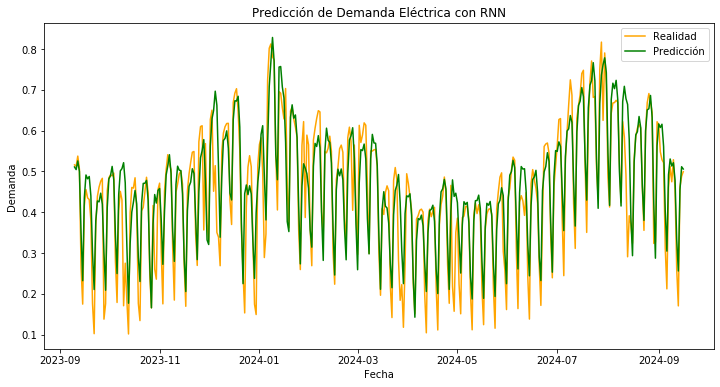

MAE: 0.05


In [45]:
# Visualizar las predicciones
plt.figure(figsize=(12, 6))

# Crear un rango de fechas que coincide con las predicciones
date_range = data_test.index[time_step: len(predictions) + time_step]

plt.plot(date_range, y_test_scaled, label='Realidad', color='orange')
plt.plot(date_range, predictions, label='Predicción', color='green')

plt.title('Predicción de Demanda Eléctrica con RNN')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.legend()
plt.show()

# Calcular MAE
mae = mean_absolute_error(y_test_scaled, predictions)
print(f'MAE: {mae:.2f}')


In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from kerastuner import HyperModel, RandomSearch

# Supón que 'data' ya está definida y contiene tus datos

# Separar la variable objetivo y las variables exógenas
target_column = 'demanda'
exogenous_columns = data.columns.difference([target_column]).tolist()

# Escalar solo la columna objetivo
scaler_target = MinMaxScaler(feature_range=(0, 1))
data[target_column] = scaler_target.fit_transform(data[[target_column]])

# Escalar las variables exógenas
scaler_exogenous = MinMaxScaler(feature_range=(0, 1))
data[exogenous_columns] = scaler_exogenous.fit_transform(data[exogenous_columns])

# Crear el conjunto de datos
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])  # Incluye todas las columnas
        y.append(data[i + time_step, 0])  # Solo la columna de demanda
    return np.array(X), np.array(y)

# Definir el tamaño de la ventana (número de pasos de tiempo)
time_step = 30
scaled_data = data.values  # Convierte a un array Numpy
X = create_dataset(scaled_data, time_step)
X_train, y_train = X[:len(data_train)], y[:len(data_train)]
X_val, y_val = X[len(data_train):len(data_train) + len(data_val)], y[len(data_train):len(data_train) + len(data_val)]
X_test, y_test = X[len(data_train) + len(data_val):], y[len(data_train) + len(data_val):]

# Reshape de X para ser [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Definición del modelo con Keras Tuner
class LSTMHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(LSTM(units=hp.Int('units1', min_value=50, max_value=200, step=50),
                       return_sequences=True,
                       input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(rate=hp.Float('dropout1', 0.1, 0.3, step=0.1)))
        model.add(LSTM(units=hp.Int('units2', min_value=50, max_value=200, step=50),
                       return_sequences=False))
        model.add(Dropout(rate=hp.Float('dropout2', 0.1, 0.3, step=0.1)))
        model.add(Dense(35))
        model.add(Dense(1))  # Salida para la demanda

        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

# Configuración de Keras Tuner
hypermodel = LSTMHyperModel()
tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=10,  # Número máximo de combinaciones de hiperparámetros a probar
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_hyperopt'
)

# Realizar la búsqueda de hiperparámetros
tuner.search(X_train, y_train,
             epochs=50,
             batch_size=32,
             validation_data=(X_val, y_val))

# Obtener los mejores hiperparámetros
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Construir el modelo con los mejores hiperparámetros
model = tuner.hypermodel.build(best_hyperparameters)

# Entrenar el modelo
history = model.fit(X_train, y_train, 
                    batch_size=best_hyperparameters.get('batch_size'),
                    epochs=best_hyperparameters.get('epochs'), 
                    validation_data=(X_val, y_val), 
                    verbose=1)

# Hacer predicciones
predictions = model.predict(X_test)

# Invertir la escala de las predicciones
predictions = predictions.reshape(-1, 1)  # Cambiar a forma (n_samples, 1)
predictions = scaler_target.inverse_transform(predictions)  # Invertir solo la columna de demanda

# Invertir la escala de los valores reales
y_test_scaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Opcional: imprimir los mejores hiperparámetros
print("Mejores hiperparámetros:")
print(f"Unidades LSTM 1: {best_hyperparameters.get('units1')}")
print(f"Unidades LSTM 2: {best_hyperparameters.get('units2')}")
print(f"Dropout 1: {best_hyperparameters.get('dropout1')}")
print(f"Dropout 2: {best_hyperparameters.get('dropout2')}")


AttributeError: 'tuple' object has no attribute 'reshape'